In [102]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import datetime as dt
import arch

from financial_utils import plot_individual_stock, get_predicted_prices

plt.rcParams['figure.facecolor'] = 'white'

dashed_line_color = '#6E8AFF'
simulations_color = '#D5E0FF'
gt_color = 'black'
mean_color = '#FF2D43'
quartile_color = '#FFC7B2'

%matplotlib inline

In [103]:
# methods for the plots 

def legend_unique_labels():
    # Get existing handles and labels
    handles, labels = plt.gca().get_legend_handles_labels()

    # Filter out duplicate legend items
    unique_handles = []
    unique_labels = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_handles.append(handle)
            unique_labels.append(label)

    # Create legend with unique items
    plt.legend(unique_handles, unique_labels)

def year_ticks():
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


def get_quartiles(prices):
    quartile_5 = np.percentile(prices, 5, axis=1)
    quartile_95 = np.percentile(prices, 95, axis=1)
    return quartile_5, quartile_95

In [104]:
# Define the list of companies and their corresponding names
company_list = ["AAPL", "GOOGL", "MSFT", "AMZN"]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

# Initialize an empty DataFrame to store the close prices
close_prices_df = pd.DataFrame()

# Loop through each company
for ticker, name in zip(company_list, company_name):
    # Construct the file path
    file_path = os.path.join("../data", "financial", f"{ticker}.csv")
    
    # Read the CSV file and keep only the "close" price
    df = pd.read_csv(file_path, parse_dates=["date"])
    df = df.set_index("date")
    df.rename(columns={"close": name}, inplace=True)
    df.drop(columns=["ticker", "open", "high", "low"], inplace=True)
    
    # Merge with the existing DataFrame
    if close_prices_df.empty:
        close_prices_df = df
    else:
        close_prices_df = close_prices_df.merge(df, how="outer", left_index=True, right_index=True)

# Sort the DataFrame by date
close_prices_df.sort_index(inplace=True)

# Drop rows with NaN values
close_prices_df.dropna(inplace=True)

# Display the resulting DataFrame
print(close_prices_df)


             APPLE  GOOGLE  MICROSOFT  AMAZON
date                                         
2004-08-19    0.55    2.51      27.12    1.93
2004-08-20    0.55    2.71      27.20    1.98
2004-08-23    0.56    2.74      27.24    1.97
2004-08-24    0.57    2.62      27.24    1.95
2004-08-25    0.59    2.65      27.55    2.02
...            ...     ...        ...     ...
2024-03-06  169.12  131.40     402.09  173.51
2024-03-07  169.00  134.38     409.14  176.82
2024-03-08  170.73  135.41     406.22  175.35
2024-03-11  172.75  137.67     404.52  171.96
2024-03-12  173.23  138.50     415.28  175.39

[4924 rows x 4 columns]


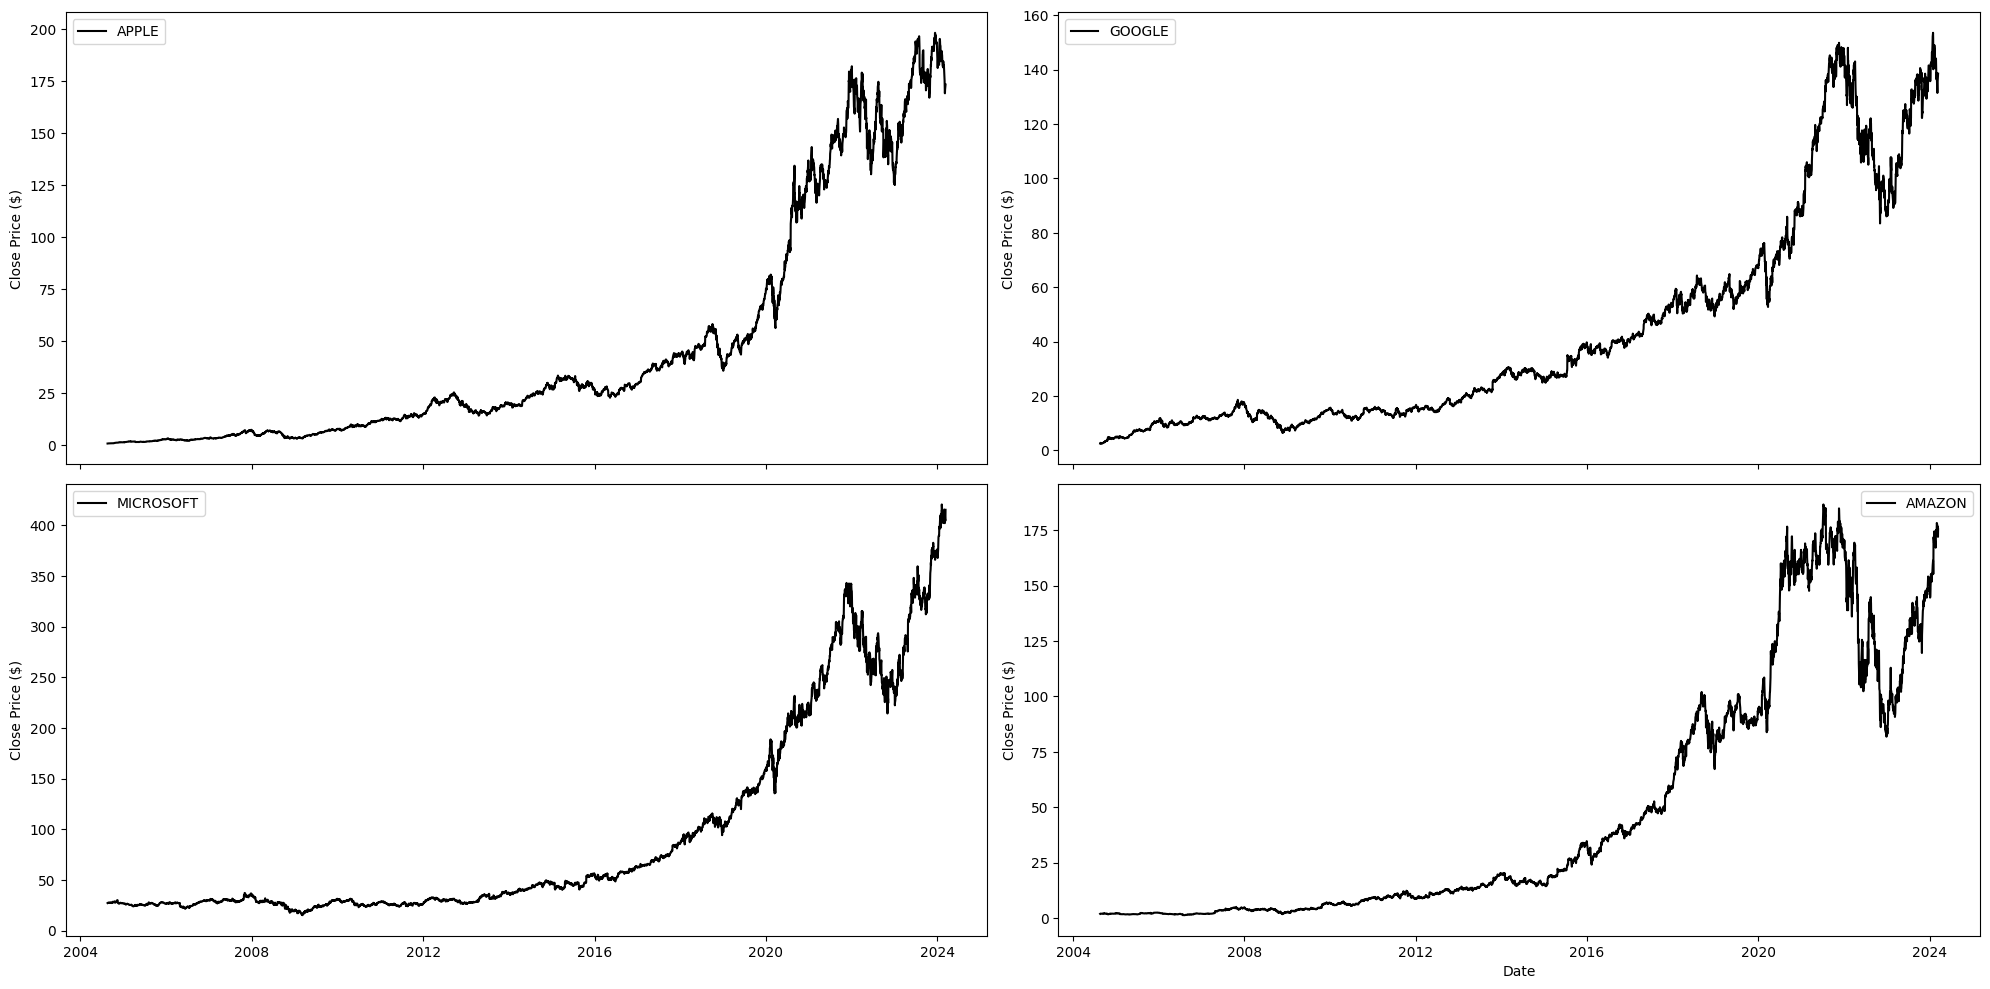

In [105]:
# Plot the time evolution for each column
fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharex=True)

for i, col_name in enumerate(close_prices_df.columns):
    row = i // 2
    col = i % 2
    axs[row, col].plot(close_prices_df.index, close_prices_df[col_name], label=col_name, color=gt_color)
    axs[row, col].set_ylabel('Close Price ($)')
    axs[row, col].legend()

# Set common labels
plt.xlabel('Date')

# Show plot
plt.tight_layout()
plt.show()



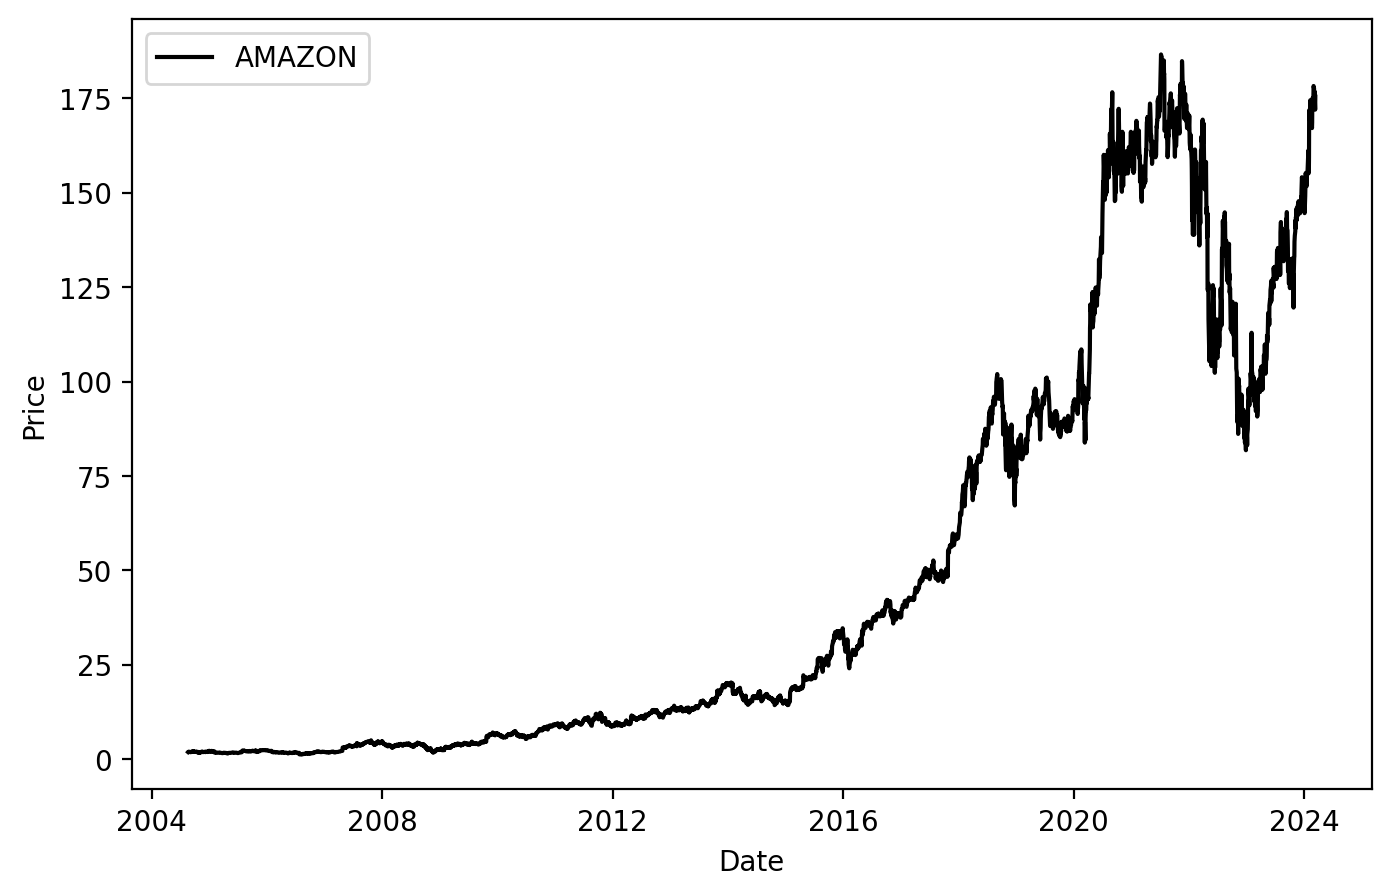

In [106]:
plot_individual_stock(df=close_prices_df, name='AMAZON', year_ticks=False)

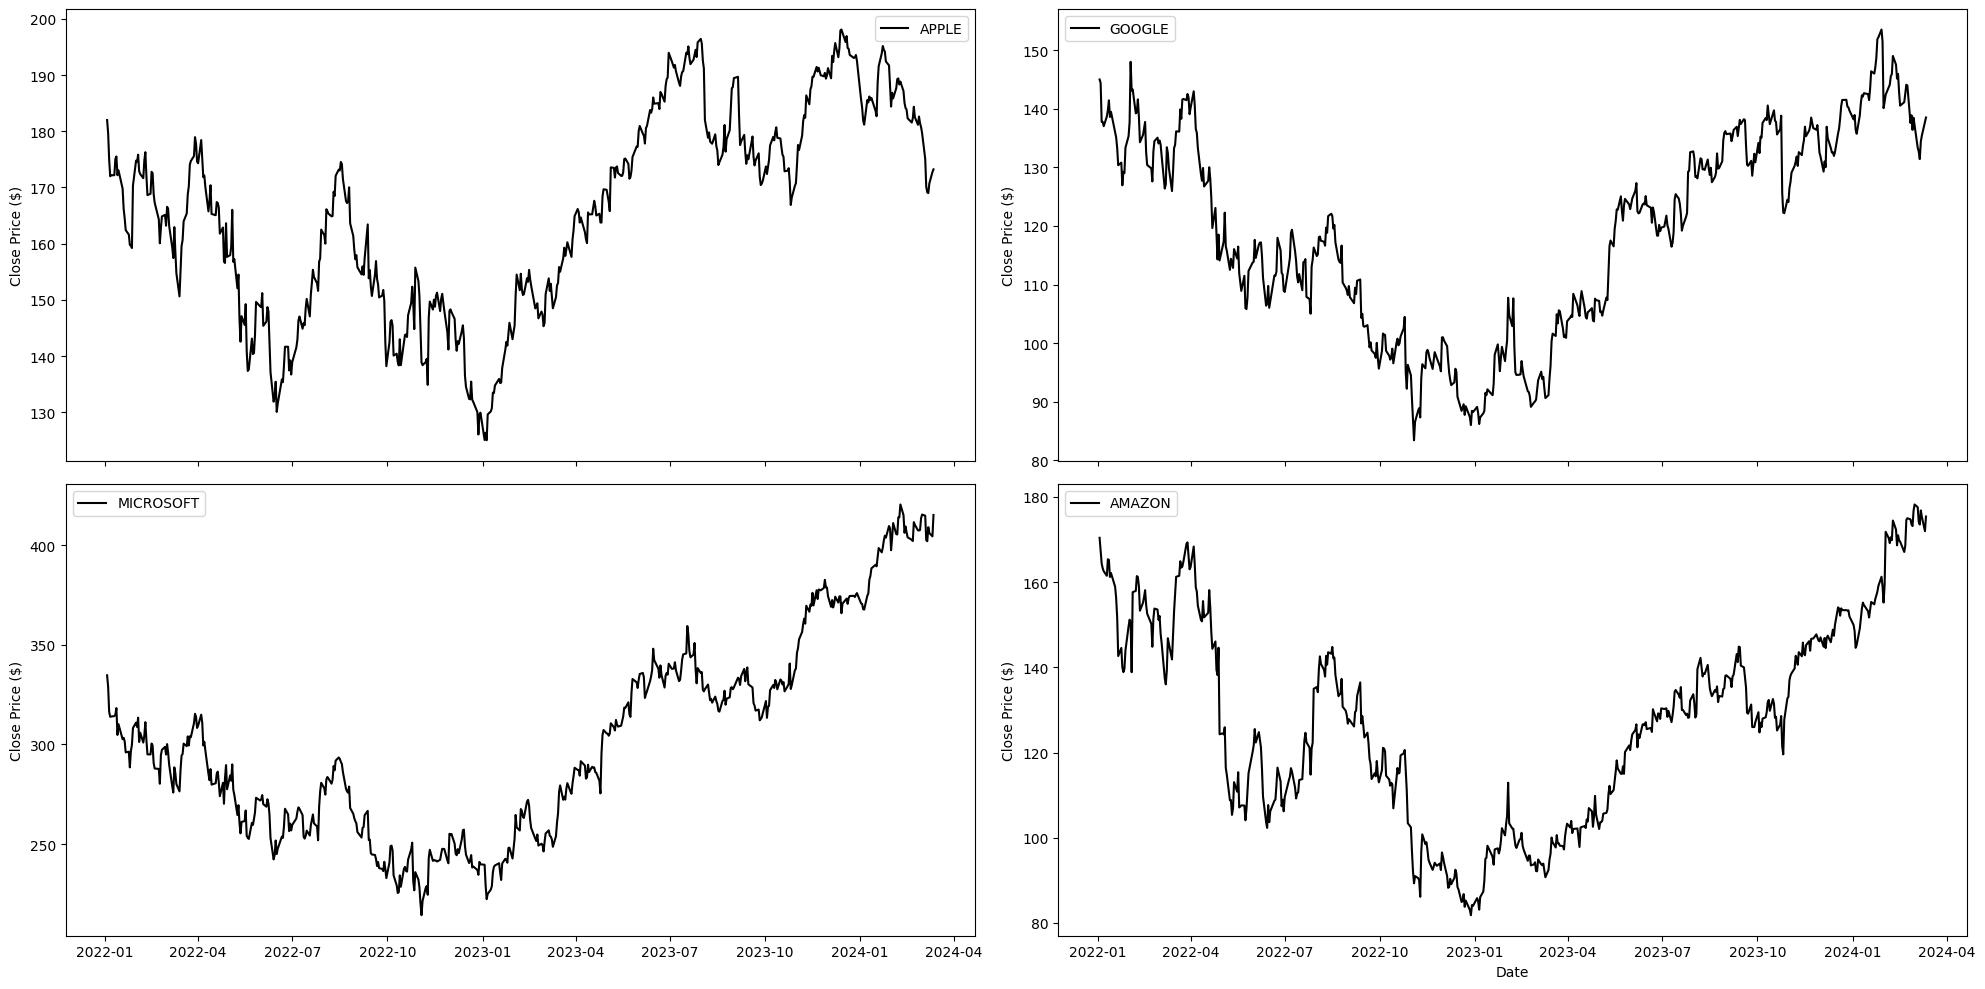

In [107]:
# Filter DataFrame to include only years after 2022
close_prices_df = close_prices_df[close_prices_df.index.year > 2021]

# Plot the time evolution for each column
fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharex=True)

for i, col_name in enumerate(close_prices_df.columns):
    row = i // 2
    col = i % 2
    axs[row, col].plot(close_prices_df.index, close_prices_df[col_name], label=col_name, color=gt_color)
    axs[row, col].set_ylabel('Close Price ($)')
    axs[row, col].legend()

# Set common labels
plt.xlabel('Date')

# Show plot
plt.tight_layout()
plt.show()

In [108]:
print(close_prices_df)


             APPLE  GOOGLE  MICROSOFT  AMAZON
date                                         
2022-01-03  182.01  144.99     334.75  170.40
2022-01-04  179.70  144.40     329.01  167.52
2022-01-05  174.92  137.77     316.38  164.36
2022-01-06  172.00  137.75     313.88  163.25
2022-01-07  172.17  137.02     314.04  162.55
...            ...     ...        ...     ...
2024-03-06  169.12  131.40     402.09  173.51
2024-03-07  169.00  134.38     409.14  176.82
2024-03-08  170.73  135.41     406.22  175.35
2024-03-11  172.75  137.67     404.52  171.96
2024-03-12  173.23  138.50     415.28  175.39

[550 rows x 4 columns]


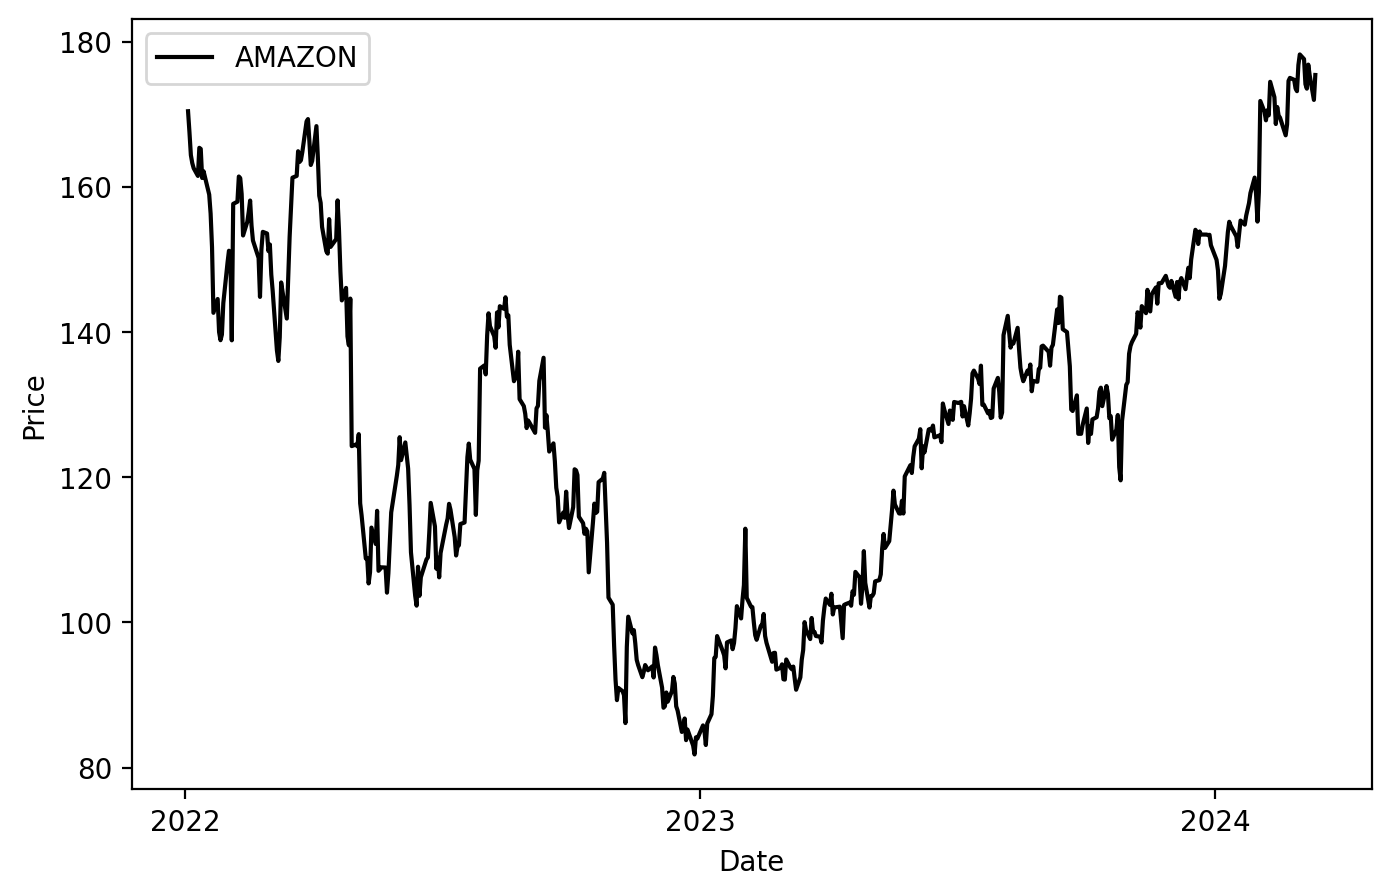

In [109]:
plot_individual_stock(df=close_prices_df, name='AMAZON', year_ticks=True)

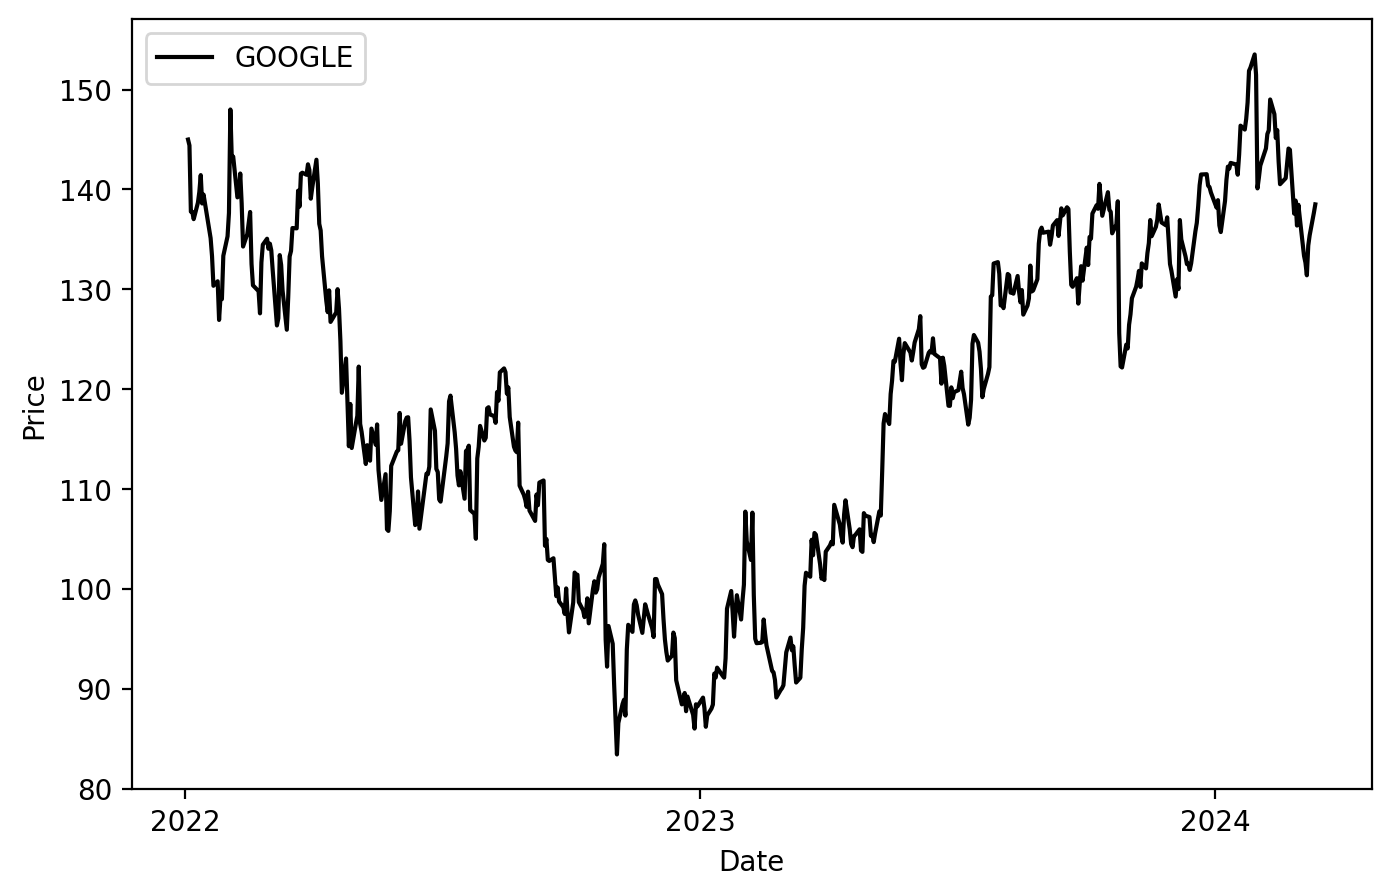

In [110]:
plot_individual_stock(df=close_prices_df, name='GOOGLE', year_ticks=True)

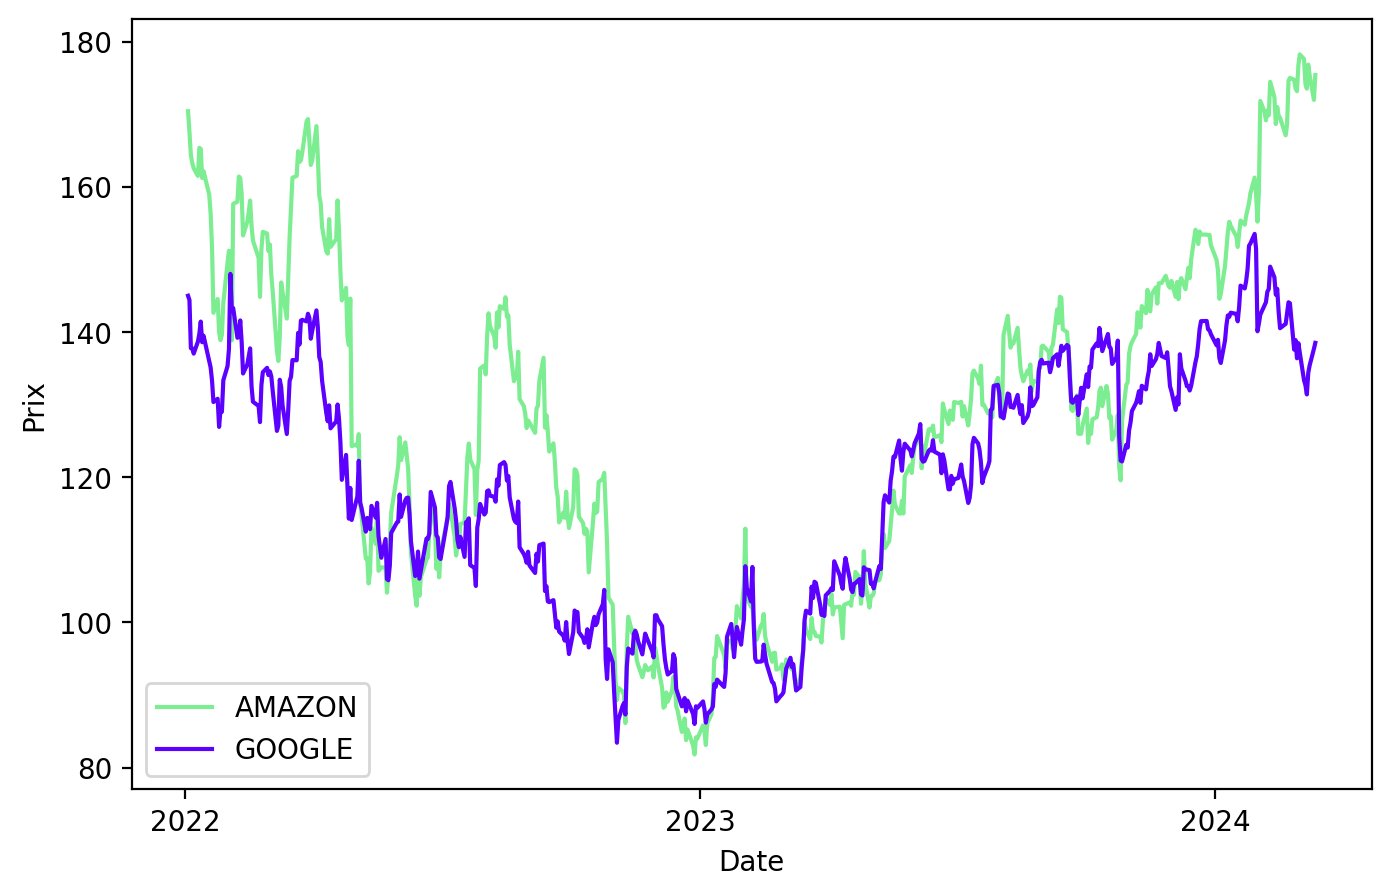

In [111]:
plt.figure(figsize=(8,5), dpi=200)
plt.plot(close_prices_df.index, close_prices_df['AMAZON'], label='AMAZON', color='#7DED92')
plt.plot(close_prices_df.index, close_prices_df['GOOGLE'], label='GOOGLE', color='#5C00FF')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Date')
plt.ylabel('Prix')
plt.legend()
plt.show()

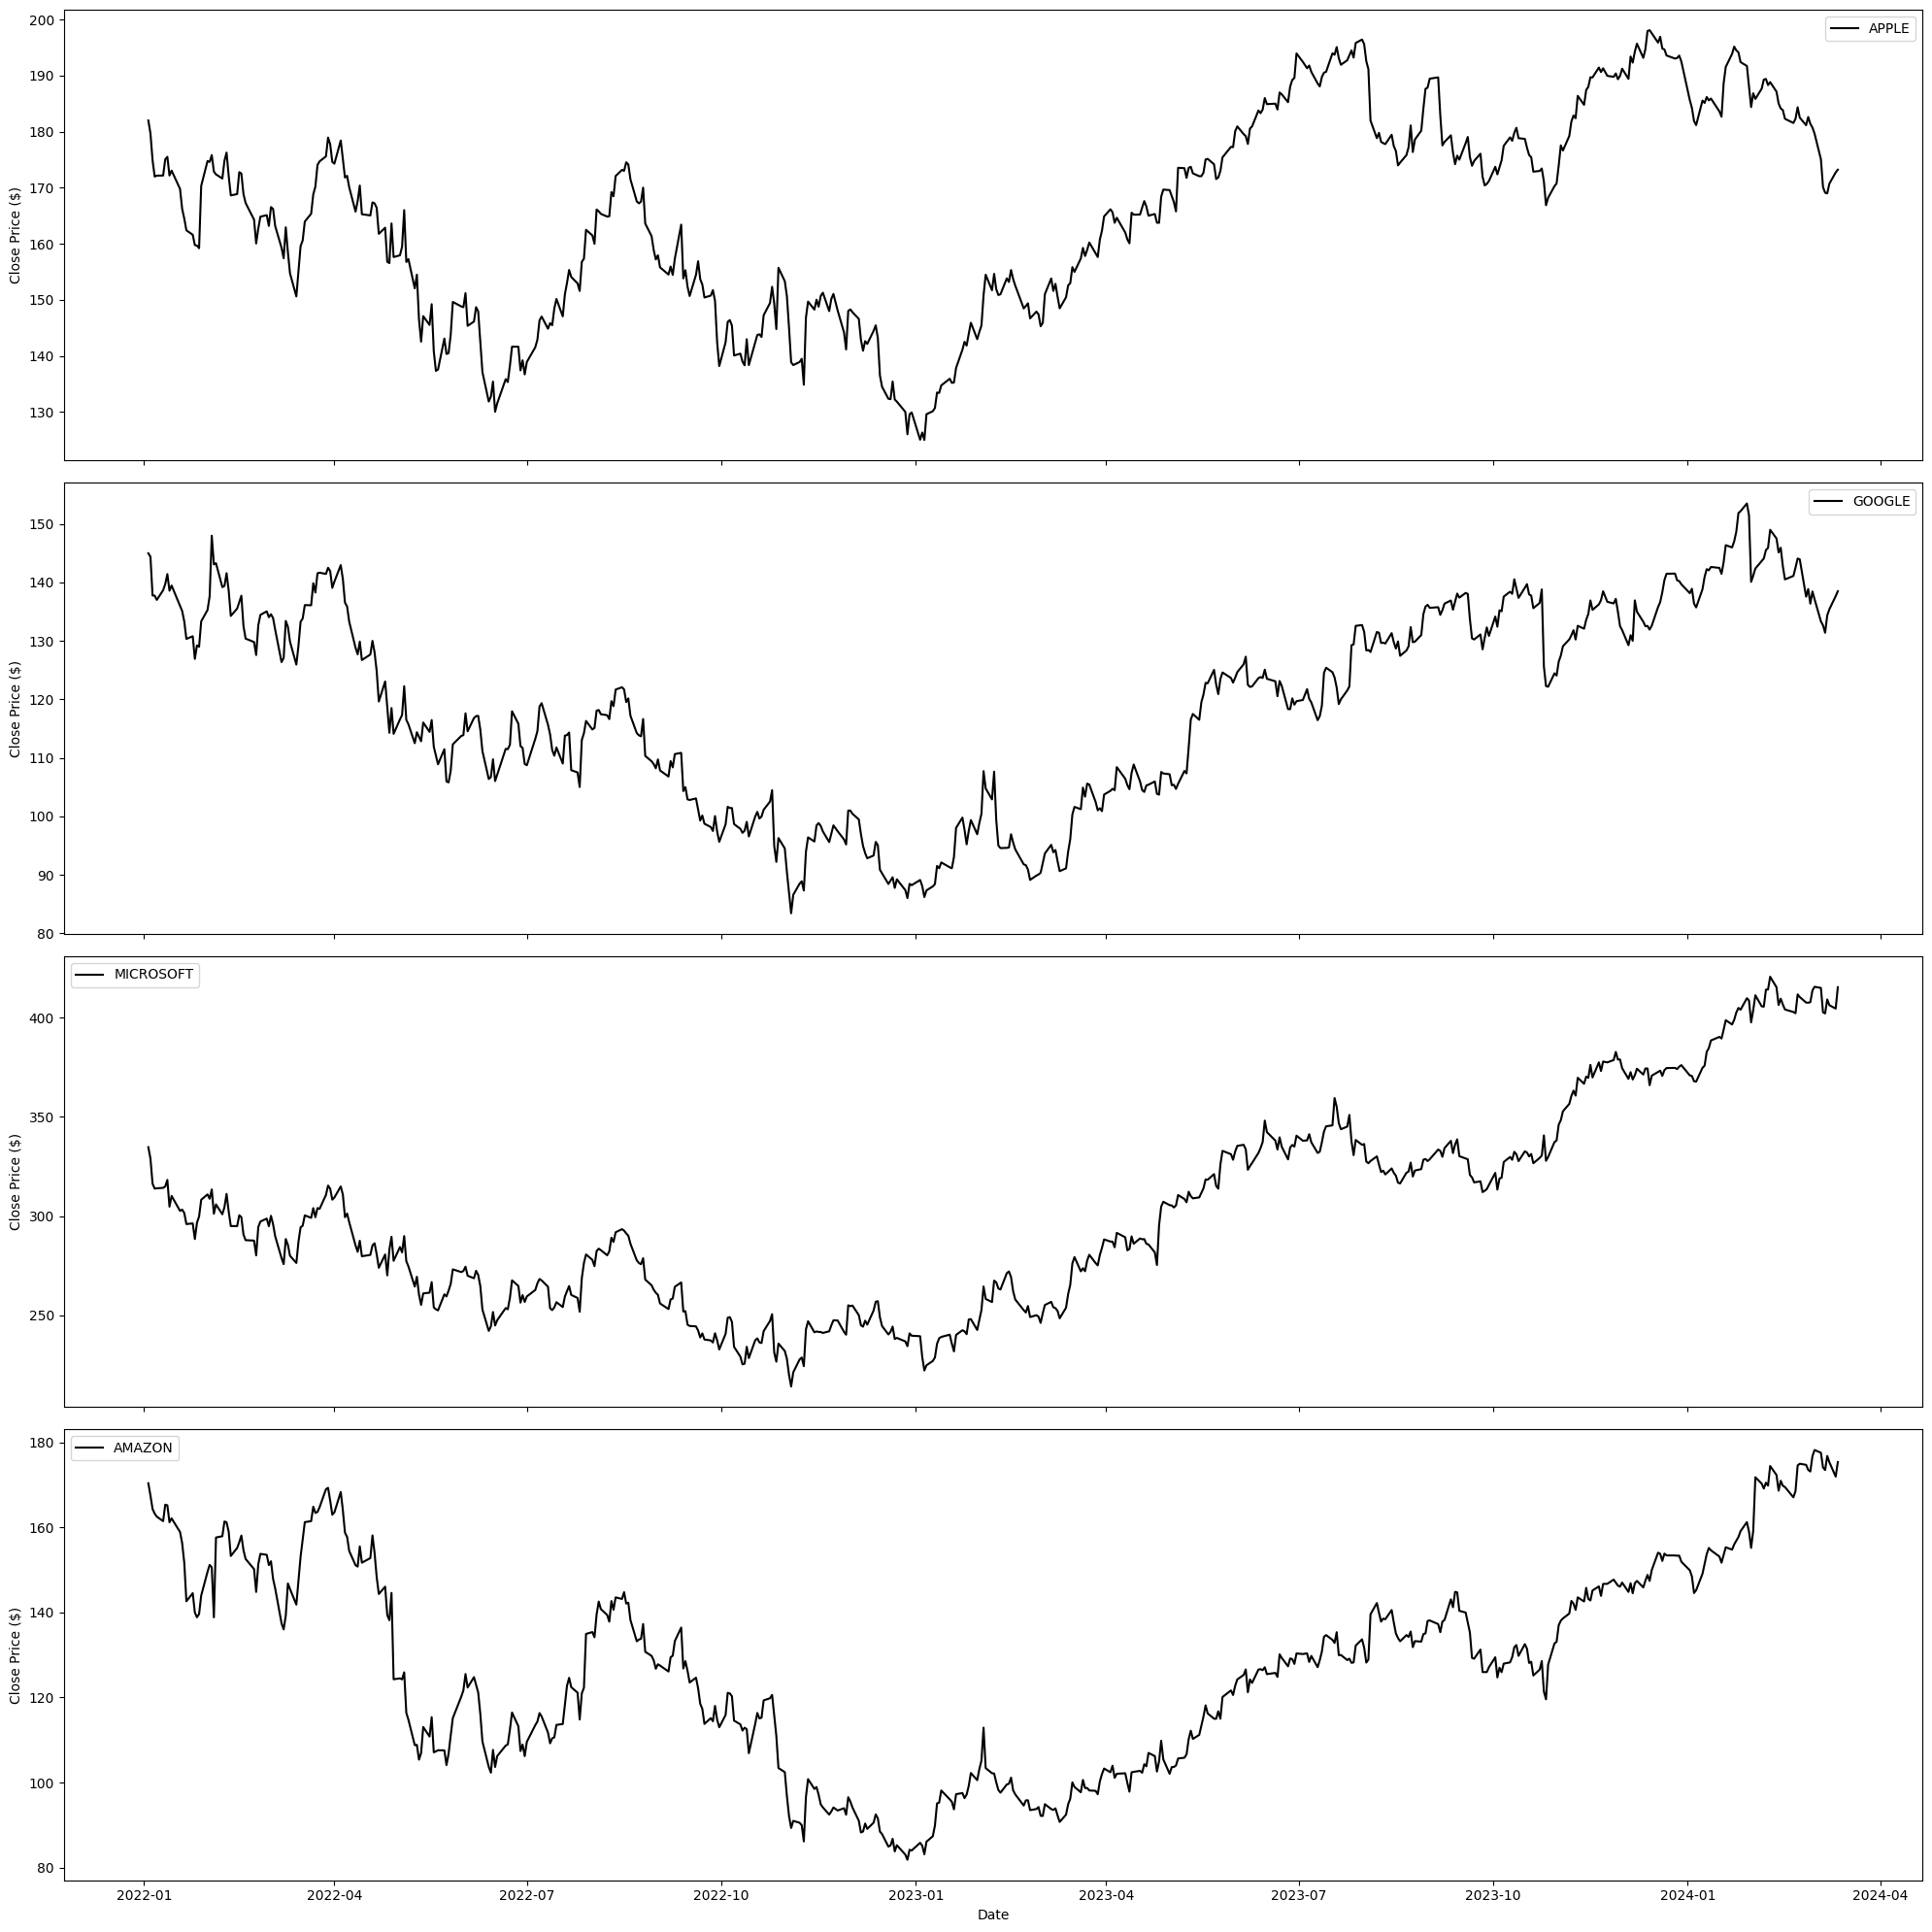

In [112]:
# Plot the time evolution for each column
fig, axs = plt.subplots(4, 1, figsize=(20, 20), sharex=True)

for i, col in enumerate(close_prices_df.columns):
    axs[i].plot(close_prices_df.index, close_prices_df[col], label=col, color=gt_color)
    axs[i].set_ylabel('Close Price ($)')
    axs[i].legend()

# Set common labels
plt.xlabel('Date')

# Show plot
plt.tight_layout()
plt.show()

GARCH

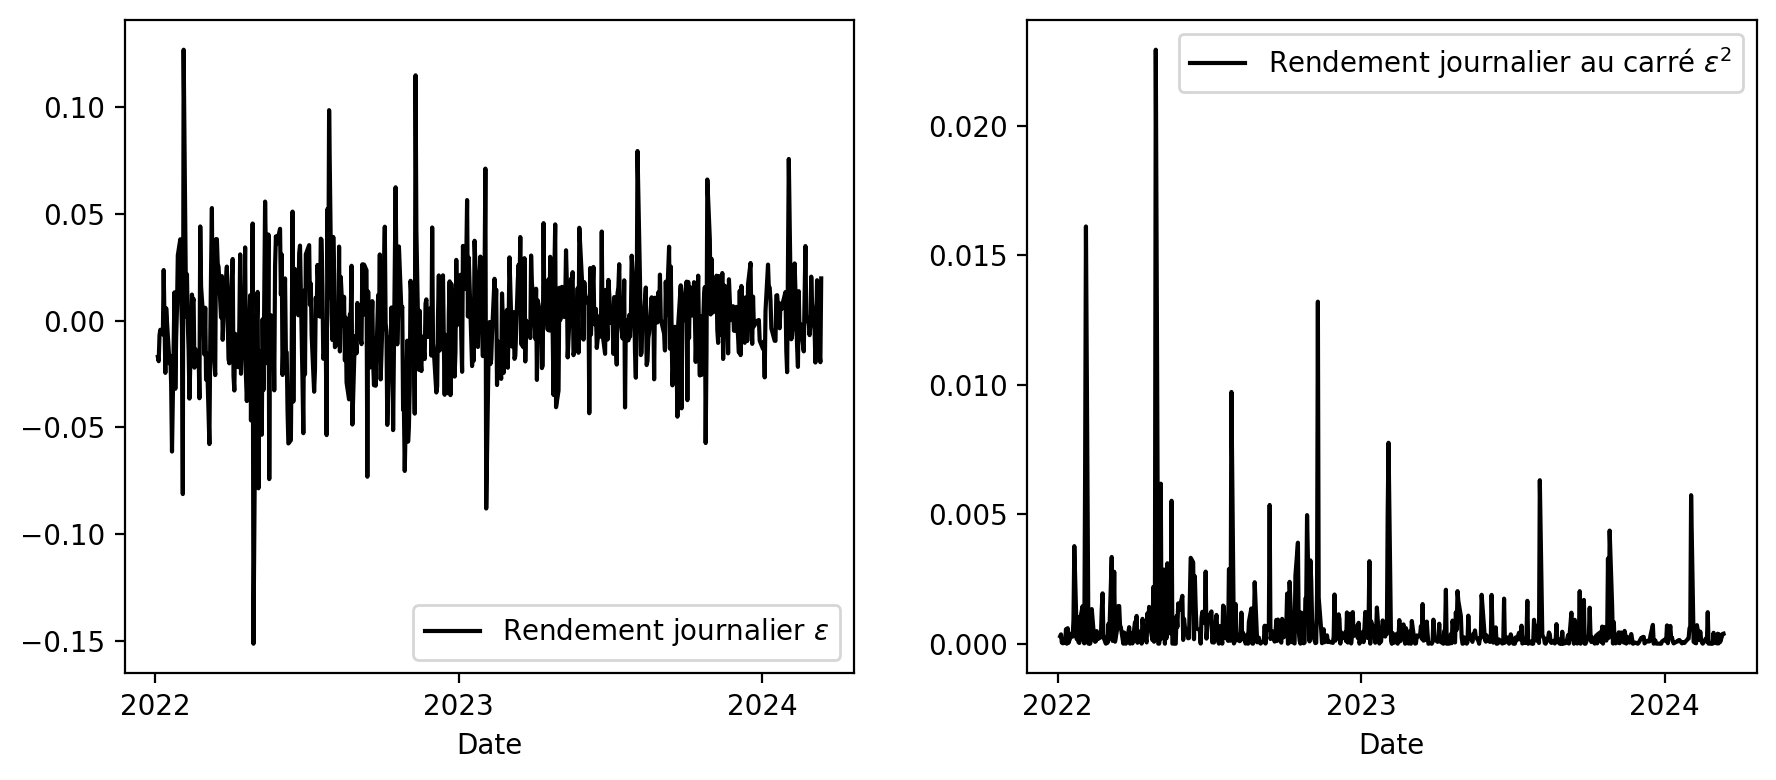

In [113]:
df_amzn = close_prices_df[['AMAZON']].copy()
df_amzn.rename(columns={'AMAZON': 'close'}, inplace=True)

# compute daily returns
df_amzn['return'] = np.log(df_amzn['close'] / df_amzn['close'].shift(1))
df_amzn['return_squared'] = df_amzn['return'] ** 2
df_amzn.dropna(inplace=True)

# Plot return and return squared in two subplots next to each other
fig, axs = plt.subplots(1, 2, figsize=(9.2,4),dpi=200)

# Plot return
axs[0].plot(df_amzn.index, df_amzn['return'], color=gt_color, label=r'Rendement journalier $\varepsilon$')
axs[0].set_xlabel('Date')
axs[0].legend()

# Plot return squared
axs[1].plot(df_amzn.index, df_amzn['return_squared'], color=gt_color, label=r'Rendement journalier au carré $\varepsilon^2$')
axs[1].set_xlabel('Date')
axs[1].legend()

# Adjust layout
plt.tight_layout()

for ax in axs:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

Fitting GARCH

In [114]:
p,q = 3,3

model = arch.arch_model(df_amzn['return'], vol='Garch', p=p, q=q)

# Specify split date
split_date = dt.datetime(2023, 6, 1)
split_index = df_amzn.index.get_loc(split_date)
x = np.arange(split_index, len(df_amzn))

# Fit GARCH(p,q) model using data up to the split date
res = model.fit(last_obs=split_date)

Iteration:      1,   Func. Count:     10,   Neg. LLF: 32300692.710182723
Iteration:      2,   Func. Count:     25,   Neg. LLF: 3903.8451330329976
Iteration:      3,   Func. Count:     35,   Neg. LLF: 560464.8804563887
Iteration:      4,   Func. Count:     46,   Neg. LLF: -680.4155282241363
Iteration:      5,   Func. Count:     56,   Neg. LLF: -754.0270900265498
Iteration:      6,   Func. Count:     66,   Neg. LLF: -749.5104003439951
Iteration:      7,   Func. Count:     76,   Neg. LLF: -753.1803542474402
Iteration:      8,   Func. Count:     86,   Neg. LLF: -709.5992827044147
Iteration:      9,   Func. Count:     96,   Neg. LLF: -755.4088504592478
Iteration:     10,   Func. Count:    105,   Neg. LLF: -755.3987276295081
Iteration:     11,   Func. Count:    115,   Neg. LLF: -755.4300854420012
Iteration:     12,   Func. Count:    124,   Neg. LLF: -755.438253430623
Iteration:     13,   Func. Count:    133,   Neg. LLF: -755.4383035797193
Iteration:     14,   Func. Count:    142,   Neg. LLF:

/Users/tessbreton/Documents/polytechnique/3A/MAP565 Modélisation aléatoire et Statistiques des processus/.venv/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008676. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [115]:
# Make forecasts
forecasts = res.forecast(horizon=len(df_amzn.index[x]), start=split_date, method="simulation")
sims = forecasts.simulations

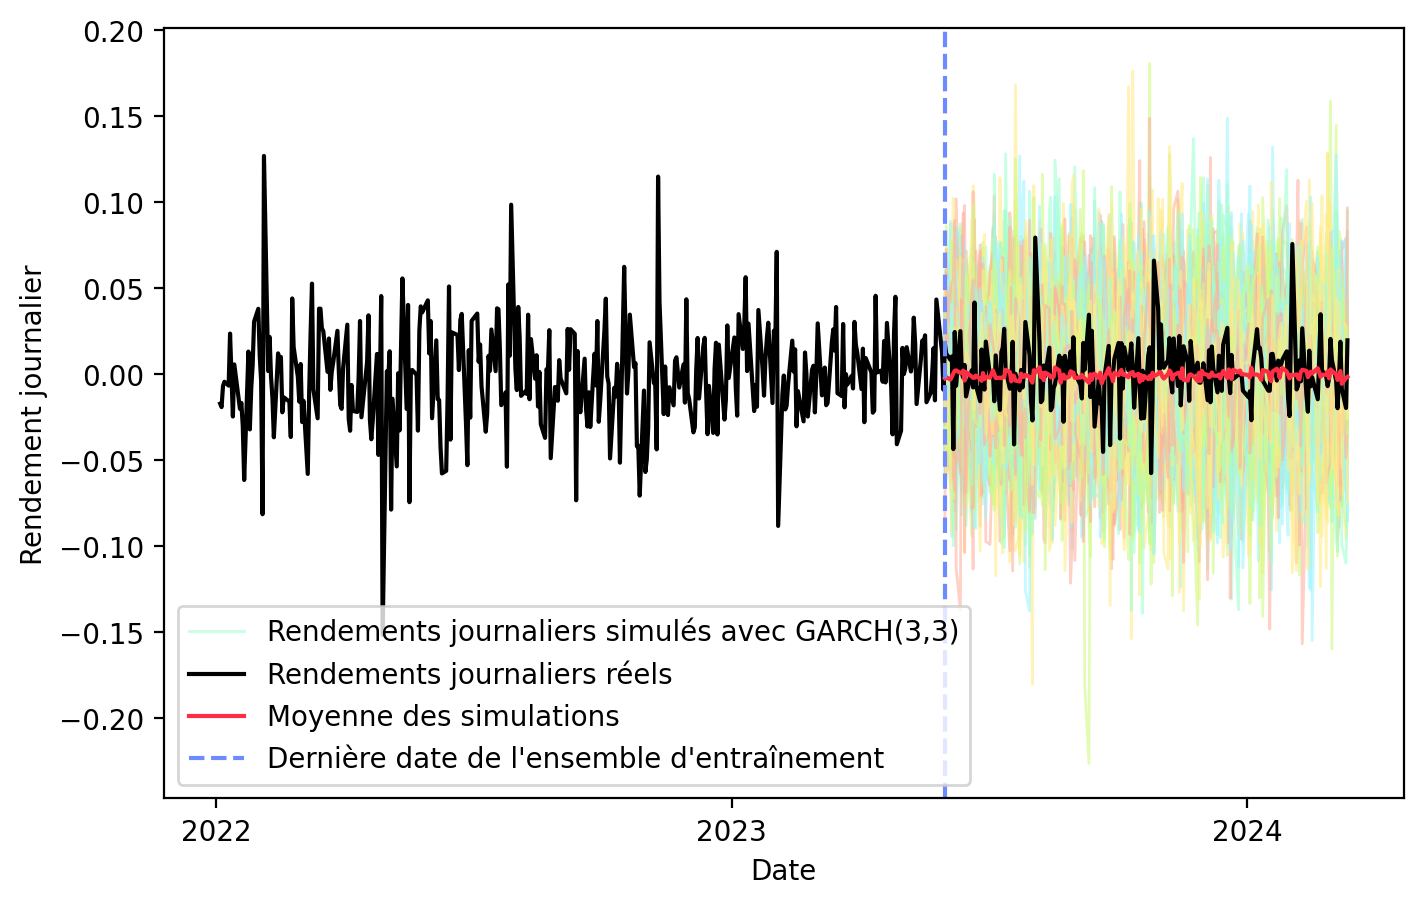

In [116]:
plt.figure(figsize=(8,5), dpi=200)

nb_sim = 200
colors = ['#A0FFCE', "#A0F4FF", "#D0FB85", "#FFB19F", "#FFEC88"]


mean_simulations = np.mean(sims.values[-1, :nb_sim], axis=0)

# Plot simulations 
for i in range(nb_sim):
    plt.plot(df_amzn.index[x], sims.values[-1, i].T, color=colors[i%5], alpha=0.6, linewidth=1, label=f'Rendements journaliers simulés avec GARCH({p},{q})')

# Plotting ground truth data
plt.plot(df_amzn.index, df_amzn['return'], label='Rendements journaliers réels', color=gt_color)

# Plot mean over all simulations for each timestamp
plt.plot(df_amzn.index[x], mean_simulations, color=mean_color, label="Moyenne des simulations")

# Plot vertical line to split train/test
plt.axvline(x=split_date, linestyle='--', color=dashed_line_color, label="Dernière date de l'ensemble d'entraînement")

plt.ylabel('Rendement journalier')
plt.xlabel('Date')
year_ticks()
legend_unique_labels()

plt.show()


In [117]:
mean_simulations

array([-2.35380898e-03, -1.64461939e-03, -3.05971030e-03, -1.20350162e-03,
        5.74691526e-04,  2.09184211e-03,  2.31162660e-03,  6.70400884e-04,
        9.38269044e-04,  2.19420705e-03, -3.56679235e-03,  1.35256687e-03,
       -1.27421358e-03, -2.02241220e-03, -2.01742124e-03, -7.06893944e-04,
       -2.70009058e-03, -3.76703530e-03,  7.34543159e-04, -2.80330704e-03,
       -1.46176817e-03, -1.88436337e-03,  2.32503246e-03,  3.91452928e-04,
       -2.15986515e-03, -1.93922129e-03, -2.27033158e-03, -1.55173835e-03,
       -1.77328517e-03,  2.66214563e-03,  1.34692413e-03, -4.11487269e-03,
       -6.98923194e-04, -1.09098066e-03, -3.62986997e-03, -4.18251117e-03,
        4.45958304e-04, -1.29555250e-03, -1.46798378e-03, -3.16272081e-04,
       -1.42640019e-03, -3.47698576e-03, -4.81860032e-03,  2.41559038e-03,
        7.82180747e-04,  4.11384885e-03, -1.66261236e-03,  8.14812991e-04,
       -3.39579917e-03,  1.05213855e-03, -3.71936645e-04, -1.75133450e-03,
       -1.11274347e-03, -

Obtenir les prédictions du cours de l'action à partir des rendements:

In [118]:
# Get the last observed closing price before the split date
prev_close = df_amzn['close'].iloc[split_index - 1]
predicted_prices = get_predicted_prices(sims, nb_sim, prev_close)

In [119]:
np.shape(predicted_prices[1:])

(196, 200)

In [120]:
type(predicted_prices[1:])

list

In [121]:
predicted_prices = predicted_prices[1:]


In [122]:
predicted_prices = np.array(predicted_prices)

In [123]:
predicted_prices

array([[118.34442896, 116.83138251, 115.47654938, ..., 121.67579528,
        117.12333598, 117.48763657],
       [113.44039046, 118.43691695, 125.90915758, ..., 121.77857549,
        120.69135555, 117.76306628],
       [107.68797449, 121.21002454, 128.6840259 , ..., 123.07384506,
        126.95167653, 118.68470224],
       ...,
       [130.96413081, 160.67823957,  91.46683738, ...,  53.04884125,
        114.39717226, 149.04956086],
       [126.88222958, 164.34895683,  93.64990627, ...,  54.53221537,
        115.5190405 , 151.06558758],
       [133.34792388, 160.61776005,  92.2540956 , ...,  52.68386564,
        113.62750217, 147.26023427]])

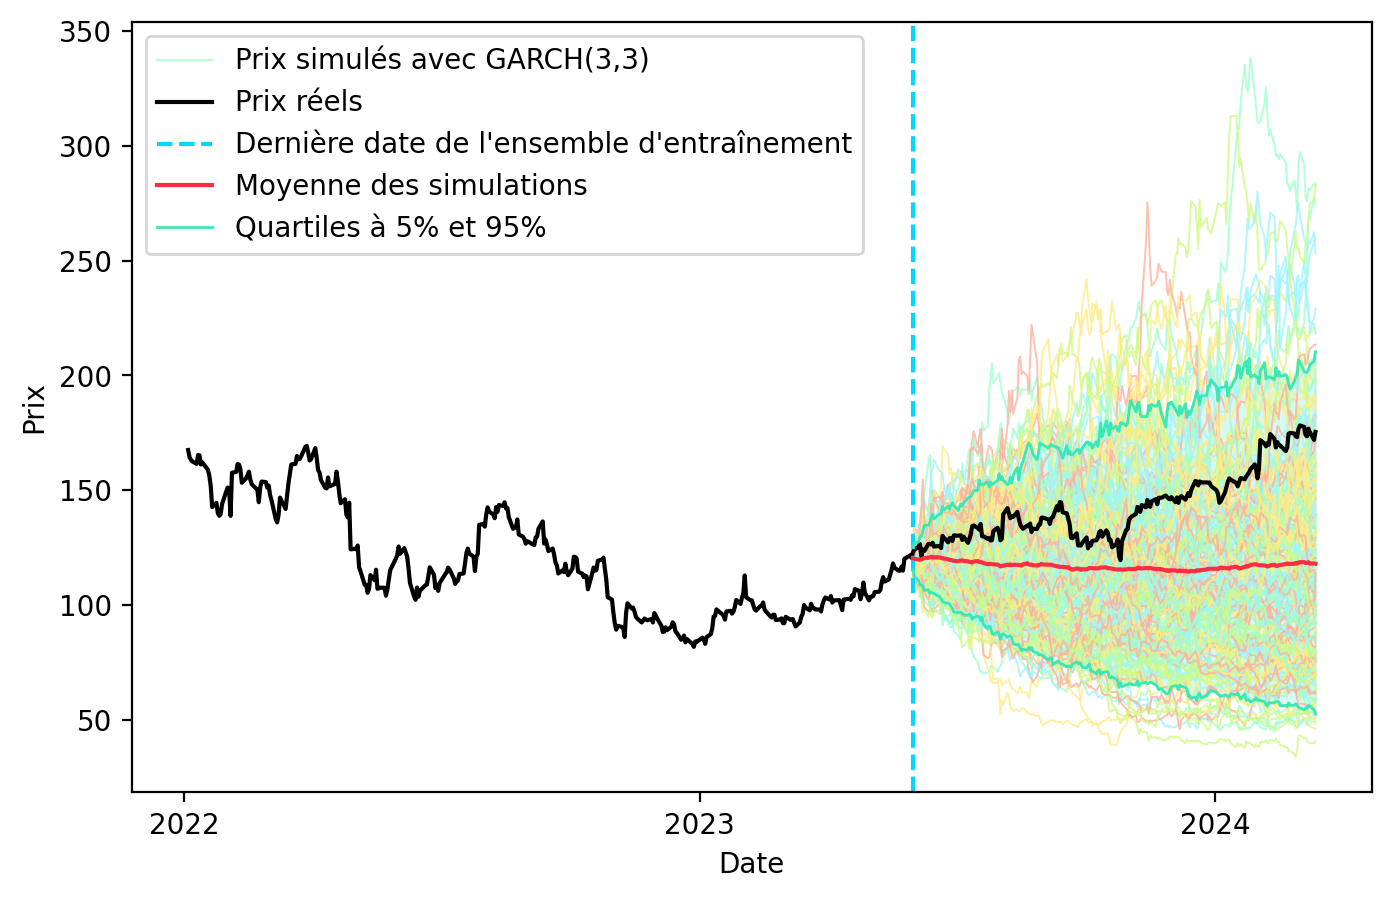

In [124]:
plt.figure(figsize=(8, 5), dpi=200)
quartile_color = '#4E62FF'
dashed_line_color = '#00D8FF'
x_pred = df_amzn.index[x]
for i in range(np.shape(predicted_prices)[1]):
    plt.plot(x_pred, predicted_prices[:,i], color=colors[i%5], alpha=0.8, linewidth=0.7, label=f"Prix simulés avec GARCH({p},{q})")
plt.plot(df_amzn.index, df_amzn['close'], label='Prix réels', color=gt_color)
plt.axvline(x=split_date, linestyle='--', color=dashed_line_color, label="Dernière date de l'ensemble d'entraînement")
plt.plot(x_pred, np.mean(predicted_prices,axis=1), label='Moyenne des simulations', color=mean_color)

quartile_color ='#3BE7B6'
# Plot quartile lines
quartile_5, quartile_95 = get_quartiles(predicted_prices)
plt.plot(x_pred, quartile_5, color=quartile_color, lw=1, label='Quartiles à 5% et 95%')
plt.plot(x_pred, quartile_95, color=quartile_color, lw=1)
plt.fill_between(x_pred, quartile_5, quartile_95, color=quartile_color, alpha=0.2)

plt.ylabel("Prix")
plt.xlabel('Date')
year_ticks()
legend_unique_labels()

plt.show()



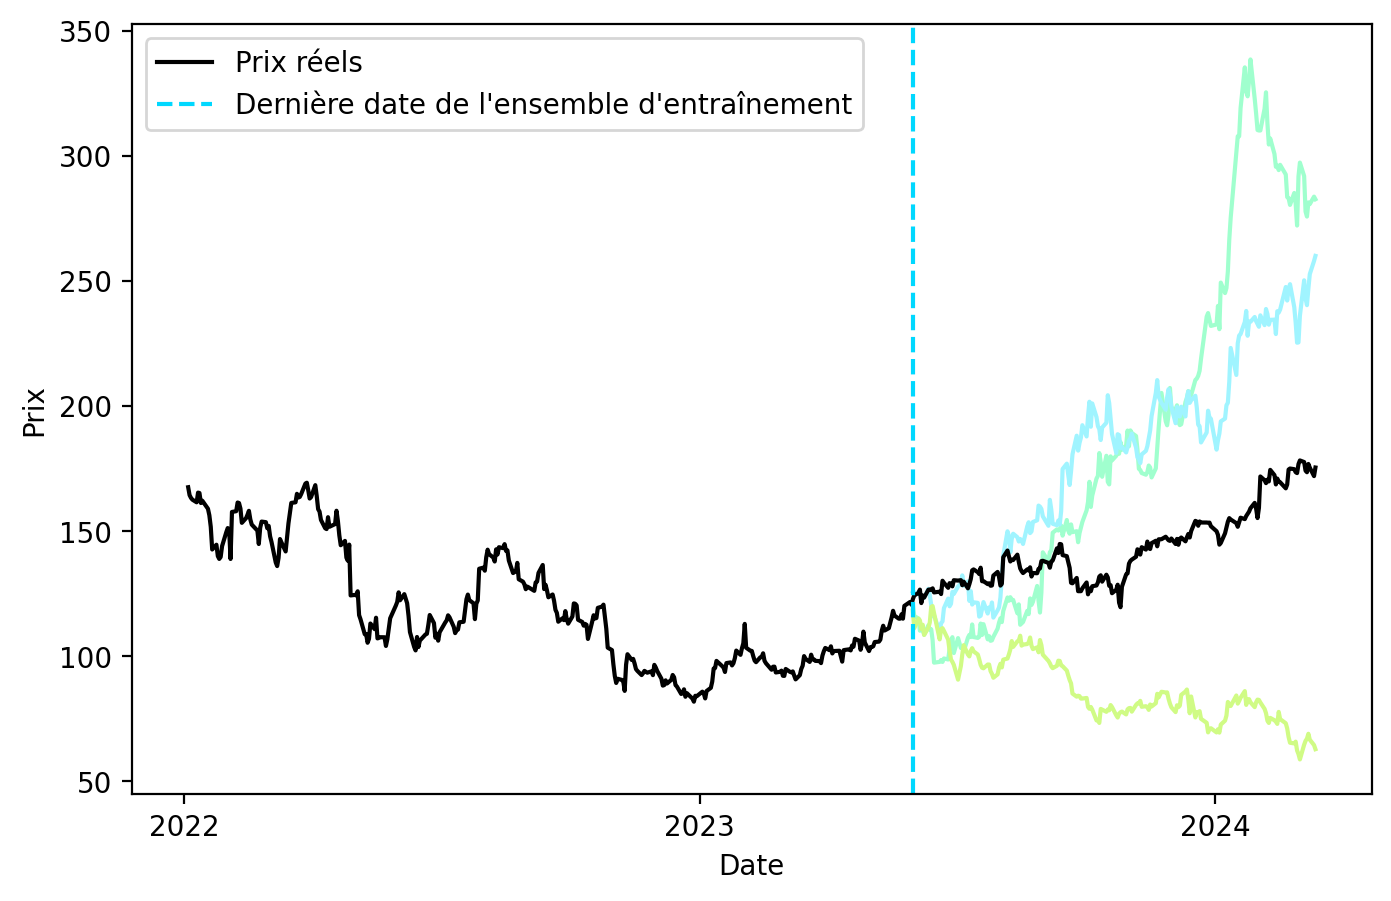

In [125]:
plt.figure(figsize=(8, 5), dpi=200)

x_pred = df_amzn.index[x]
# Array de couleurs

# Itérer sur les 5 premiers éléments de l'axe 1 et les tracer
for i in range(3):
    plt.plot(x_pred,np.array(predicted_prices)[:, i+5], color=colors[i])
plt.plot(df_amzn.index, df_amzn['close'], label='Prix réels', color=gt_color)
plt.axvline(x=split_date, linestyle='--', color=dashed_line_color, label="Dernière date de l'ensemble d'entraînement")

plt.ylabel("Prix")
plt.xlabel('Date')
year_ticks()
legend_unique_labels()

plt.show()

Prédire le cours de l'action pour les années à venir:

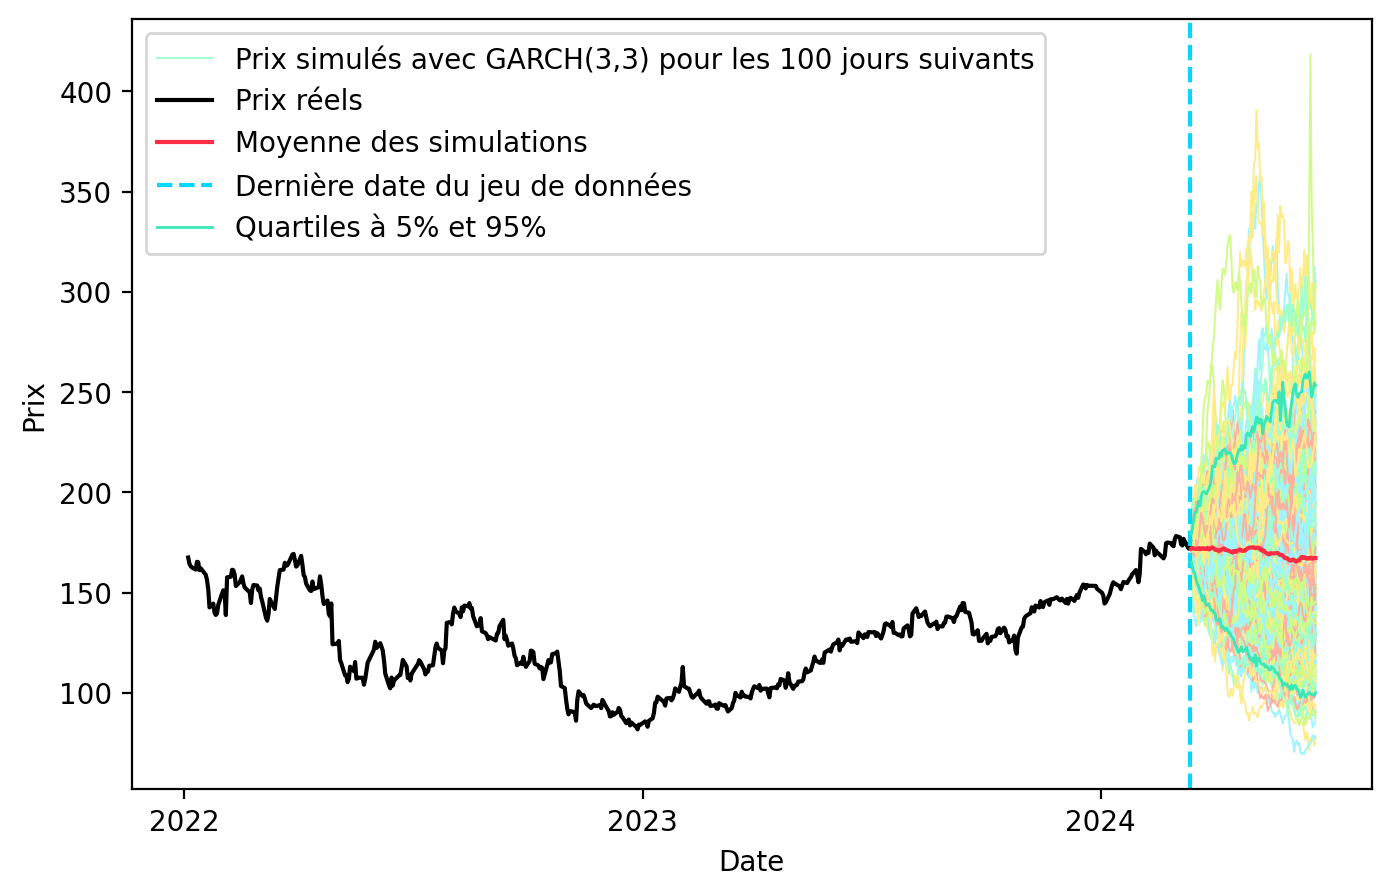

In [126]:
# Find the index of the split date in df_amzn
split_index = len(df_amzn) - 1
split_date = df_amzn.index[split_index]
prev_close = df_amzn['close'].iloc[split_index - 1]

# Set the horizon for the forecasts (100 days)
horizon = 100

# Make forecasts for the next 100 days after the split date
forecasts = res.forecast(horizon=horizon, start=split_date, method='simulation')
sims = forecasts.simulations
predicted_prices = get_predicted_prices(sims, nb_sim, prev_close)
predicted_prices = predicted_prices[1:]
predicted_prices = np.array(predicted_prices)
# Generate x-axis index for the next 100 days after the split date
x_pred = pd.date_range(start=df_amzn.index[split_index], periods=horizon + 1)[1:]

# Plot the predictions for the next 100 days after the split date
plt.figure(figsize=(8, 5),dpi=200)

for i in range(np.shape(predicted_prices)[1]):
    plt.plot(x_pred, predicted_prices[:,i], color=colors[i%5], linewidth=0.7, label=f"Prix simulés avec GARCH({p},{q}) pour les {horizon} jours suivants")
plt.plot(df_amzn.index, df_amzn['close'], label='Prix réels', color=gt_color)
plt.plot(x_pred, np.mean(predicted_prices,axis=1), label='Moyenne des simulations', color=mean_color)
plt.axvline(x=split_date, linestyle='--', color=dashed_line_color, label='Dernière date du jeu de données')

# Plot quartile lines
quartile_5, quartile_95 = get_quartiles(predicted_prices)
plt.plot(x_pred, quartile_5, color=quartile_color, lw=1, label='Quartiles à 5% et 95%')
plt.plot(x_pred, quartile_95, color=quartile_color, lw=1)
plt.fill_between(x_pred, quartile_5, quartile_95, color=quartile_color, alpha=0.2)

plt.ylabel("Prix")
plt.xlabel('Date')
year_ticks()
legend_unique_labels()

plt.show()


# Copules

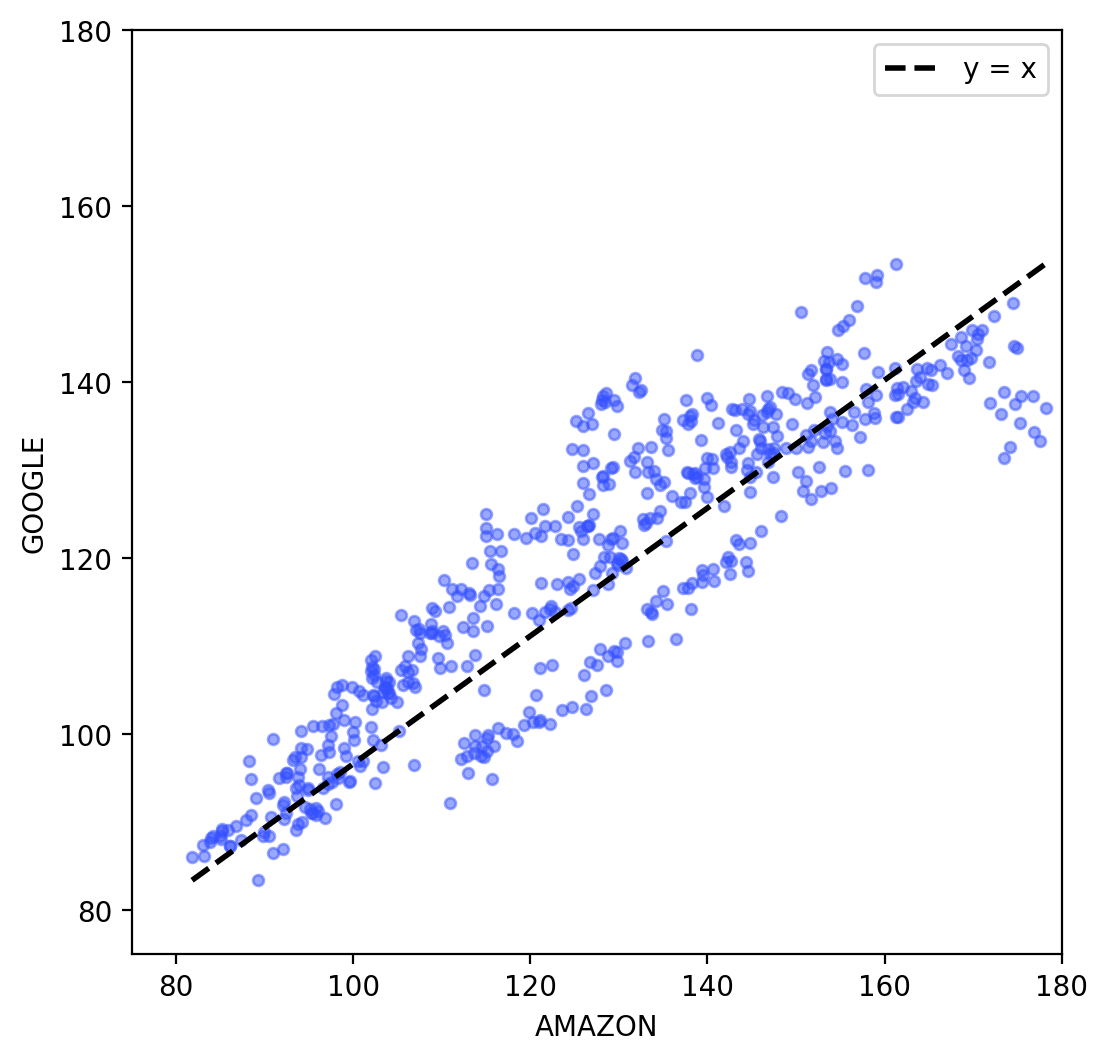

\subsection{Analyse de dépendance copule entre AMAZON et GOOGLE}
Le coefficient de corrélation linéaire entre AMAZON et GOOGLE est : 0.9034.


In [127]:
import numpy as np
import pandas as pd
import copulalib as cl
import matplotlib.pyplot as plt


# Sélection des colonnes pour AMAZON et GOOGLE
amazon = close_prices_df['AMAZON'].values.reshape(-1, 1)
google = close_prices_df['GOOGLE'].values.reshape(-1, 1)

# Calcul du coefficient de corrélation linéaire
correlation = np.corrcoef(amazon.flatten(), google.flatten())[0, 1]

plt.figure(figsize=(6,6),dpi=200)
# Affichage du scatter plot avec la droite y=x
plt.scatter(amazon, google, alpha=0.5, color='#3551FF',s=15)
plt.plot([min(amazon), max(amazon)], [min(google), max(google)], linestyle='--', color='black', lw=2, label='y = x')
plt.xlabel('AMAZON')
plt.ylabel('GOOGLE')
plt.xlim(75,180)
plt.ylim(75,180)

plt.legend()
plt.show()


# Rapport en LaTeX
print("\\subsection{Analyse de dépendance copule entre AMAZON et GOOGLE}")
print(f"Le coefficient de corrélation linéaire entre AMAZON et GOOGLE est : {correlation:.4f}.")



In [128]:
amazon = amazon[:,0]
google = google[:,0]

Gumbel
Kendall's rank correlation :  0.7397308371383315
Spearmen's correlation :  0.9086787797402931
Pearson's correlation :  0.9033571672502043
thetas
5.684352529550297
13.4954833984375
3.8421762647751483


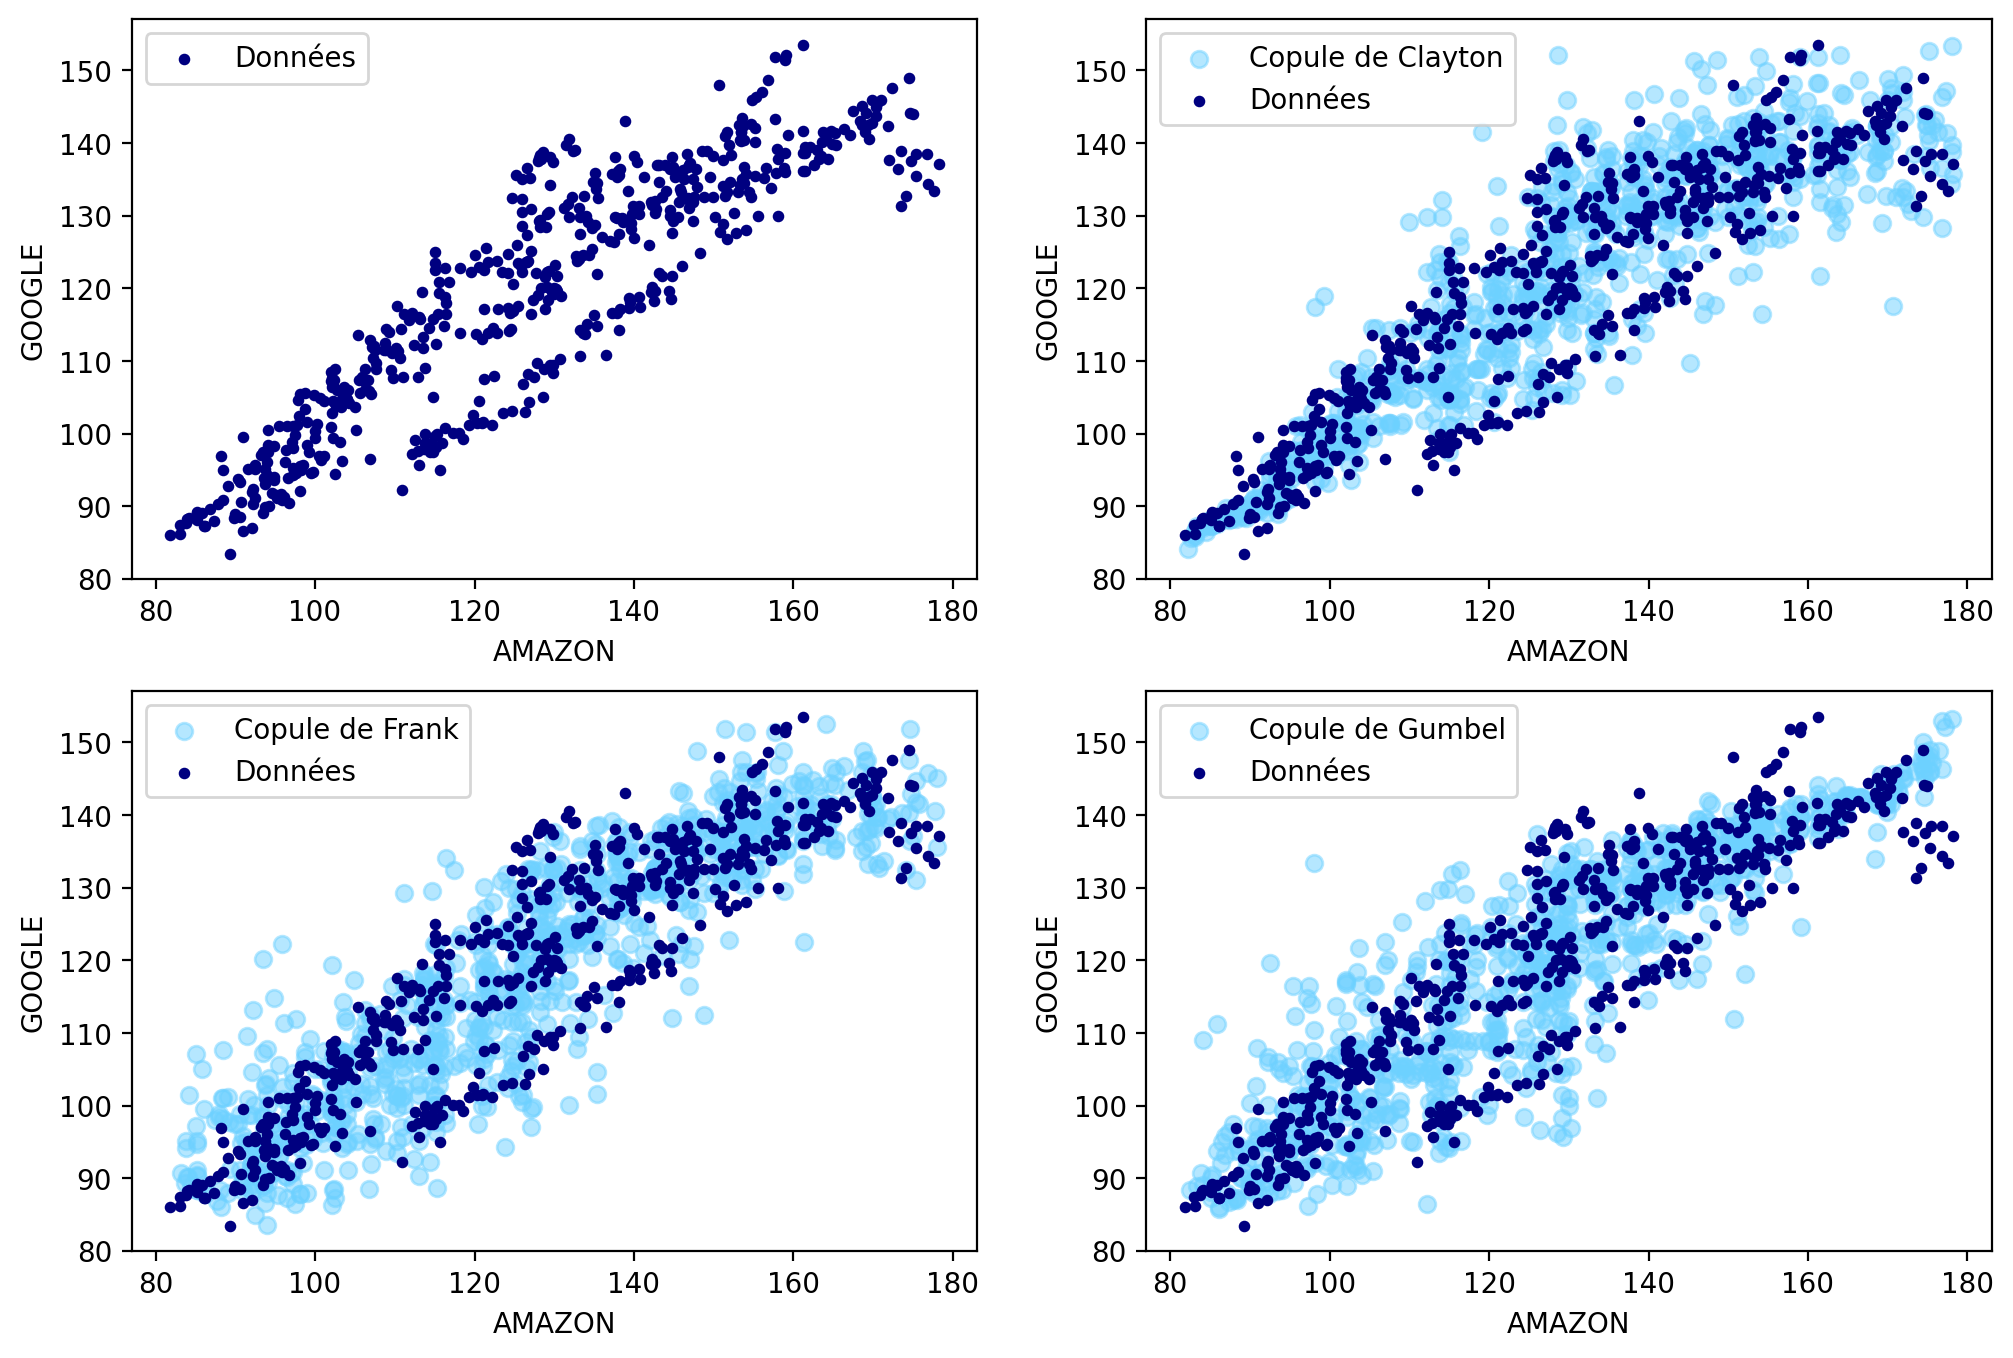

In [129]:
from copulalib.copulalib import Copula

true_color = 'navy'
copula_color = '#6DD1FF'
alpha = 0.5

x,y = amazon, google

plt.figure(figsize=(12,8),dpi=200)
plt.subplot(221)
plt.scatter(x, y, color=true_color,s=10, label='Données')
plt.xlabel('AMAZON')
plt.ylabel('GOOGLE')
plt.legend()

# make the instance of Copula class with x, y and clayton family
foo_clayton = Copula(x, y, family='clayton')
foo_frank = Copula(x, y, family='frank')
foo_gumbel = Copula(x, y, family='gumbel')

print('Gumbel')
# print the Kendall's rank correlation
print("Kendall's rank correlation : ", foo_gumbel.tau) 
# print spearmen's correlation
print("Spearmen's correlation : ", foo_gumbel.sr)
# print pearson's correlation
print("Pearson's correlation : ", foo_gumbel.pr)

print('thetas')
# print the parameter (theta) of copula
print(foo_clayton.theta)
print(foo_frank.theta)
print(foo_gumbel.theta)

# generate the 1000 samples (U,V) of copula
X1, Y1 = foo_clayton.generate_xy(1000)
X2, Y2 = foo_frank.generate_xy(1000)
X3, Y3 = foo_gumbel.generate_xy(1000)

plt.subplot(222)
plt.scatter(X1, Y1, color=copula_color, alpha=alpha, label='Copule de Clayton')
plt.scatter(x,y, color=true_color,s=10, label='Données')
plt.xlabel('AMAZON')
plt.ylabel('GOOGLE')
plt.legend()


plt.subplot(223)
plt.scatter(X2, Y2, color=copula_color, alpha=alpha, label='Copule de Frank')
plt.scatter(x,y, color=true_color,s=10, label='Données')
plt.xlabel('AMAZON')
plt.ylabel('GOOGLE')
plt.legend()


plt.subplot(224)
plt.scatter(X3, Y3, color=copula_color, alpha=alpha, label='Copule de Gumbel')
plt.scatter(x,y, color=true_color,s=10, label='Données')
plt.xlabel('AMAZON')
plt.ylabel('GOOGLE')
plt.legend()

plt.show()


In [130]:
len(x)

550

In [131]:
from scipy.stats import pearsonr, spearmanr, kendalltau
import numpy as np
print('True Data')
pearson, spearman, kendall = pearsonr(amazon, google)[0], spearmanr(amazon, google)[0], kendalltau(amazon, google)[0]
print('pearson : {:.3f}, spearman : {:.3f}, kendall : {:.3f}'.format(pearson, spearman, kendall))

# Filtrer les valeurs NaN et infinies dans les deux listes
valid_indices = ~np.isnan(X1) & ~np.isnan(Y1) & ~np.isinf(X1) & ~np.isinf(Y1)
X1_filtered = X1[valid_indices]
Y1_filtered = Y1[valid_indices]

# Calculer le coefficient de corrélation de Pearson
pearson1 = pearsonr(X1_filtered, Y1_filtered)[0]
spearman1 = spearmanr(X1_filtered, Y1_filtered)[0]
kendall1 = kendalltau(X1_filtered, Y1_filtered)[0]
print('Clayton')
print('pearson : {:.3f}, spearman : {:.3f}, kendall : {:.3f}'.format(pearson1, spearman1, kendall1))

# Filtrer les valeurs NaN et infinies dans les deux listes
valid_indices = ~np.isnan(X2) & ~np.isnan(Y2) & ~np.isinf(X2) & ~np.isinf(Y2)
X2_filtered = X2[valid_indices]
Y2_filtered = Y2[valid_indices]

# Calculer le coefficient de corrélation de Pearson
pearson2 = pearsonr(X2_filtered, Y2_filtered)[0]
spearman2 = spearmanr(X2_filtered, Y2_filtered)[0]
kendall2 = kendalltau(X2_filtered, Y2_filtered)[0]
print('Frank')
print('pearson : {:.3f}, spearman : {:.3f}, kendall : {:.3f}'.format(pearson2, spearman2, kendall2))

# Filtrer les valeurs NaN et infinies dans les deux listes
valid_indices = ~np.isnan(X3) & ~np.isnan(Y3) & ~np.isinf(X3) & ~np.isinf(Y3)
X3_filtered = X3[valid_indices]
Y3_filtered = Y3[valid_indices]

# Calculer le coefficient de corrélation de Pearson
pearson3 = pearsonr(X3_filtered, Y3_filtered)[0]
spearman3 = spearmanr(X3_filtered, Y3_filtered)[0]
kendall3 = kendalltau(X3_filtered, Y3_filtered)[0]
print('Gumbel')
print('pearson : {:.3f}, spearman : {:.3f}, kendall : {:.3f}'.format(pearson3, spearman3, kendall3))



True Data
pearson : 0.903, spearman : 0.909, kendall : 0.740
Clayton
pearson : 0.903, spearman : 0.904, kendall : 0.743
Frank
pearson : 0.902, spearman : 0.914, kendall : 0.737
Gumbel
pearson : 0.906, spearman : 0.915, kendall : 0.753
